# Descripción

**Objetivo:** Find the real confounders from a subset of candidate features

Build causal graph with Z → find sets that satisfy Backdoor Criterion



# Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from dowhy import CausalModel
from castle.common import GraphDAG
from castle.algorithms import PC
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.FCMBased import lingam
from causallearn.search.ScoreBased.GES import ges

from config import TREATMENT, OUTCOME
from utils.preprocessing import create_stratification_split_col
from utils.graphs import (
    get_nx_graph_FCI,
    create_prior,
    get_edges_list_from_gcastlegraph,
    redirect_edges_by_domain_knownledge,
    analyze_dag_issues,
    make_dag,
    get_outcome_only_causes,
    get_nx_graph_ges,
    # test_all_independences
)

# display
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")


2025-01-24 11:14:40,205 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2025-01-24 11:14:40,308 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


# Env variables

In [2]:
CONTROLS_CANDIDATES_PATH = "data/controls_candidates.txt"
CONTROLS_PATH = "data/controls.txt"
OUTCOME_CAUSES_PATH = "data/outcome_causes.txt"

# Utils

# Data

In [3]:
with open(CONTROLS_CANDIDATES_PATH) as f:
    controls_candidates = f.read().split("\n")
controls_candidates = [c for c in controls_candidates if c != ""]
controls_candidates

['redundantfeature28_n_loans',
 'n_accounts',
 'default_debt_amount',
 'years_since_default',
 'n_loans',
 'loss_given_default',
 'redundantfeature4_n_loans',
 'n_refin',
 'years_history',
 'debt_cirbe',
 'redundantfeature37_n_loans',
 'redundantfeature93_years_since_default',
 'n_cards']

In [4]:
df = pd.read_parquet("data/synthetic_data.parquet", columns=[TREATMENT, OUTCOME] + controls_candidates)

In [5]:
strat_feature = create_stratification_split_col(df, TREATMENT, OUTCOME)
train, test = train_test_split(
    df, test_size=0.2, random_state=42, 
    stratify=strat_feature,
)

print(train.shape, test.shape)

(12000, 15) (3000, 15)


In [6]:
# Scale
features_scale = controls_candidates + [TREATMENT]
train_scaled = train.copy()
test_scaled = test.copy()

scaler = StandardScaler()
train_scaled[features_scale] = pd.DataFrame(
    scaler.fit_transform(train[features_scale]), columns=features_scale, index=train.index
)
test_scaled[features_scale] = pd.DataFrame(
    scaler.transform(test[features_scale]), columns=features_scale, index=test.index
)

# 1rst iter identification - 100% algorithm driven

We force some priors as we know that the covariates always happen before the treatment assignment and
the ouctome always happens after the treatment assignment.

In [7]:
features_graph = controls_candidates + [TREATMENT, OUTCOME]

## PC

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


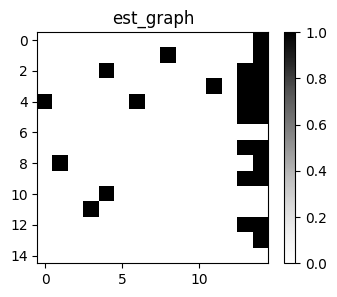

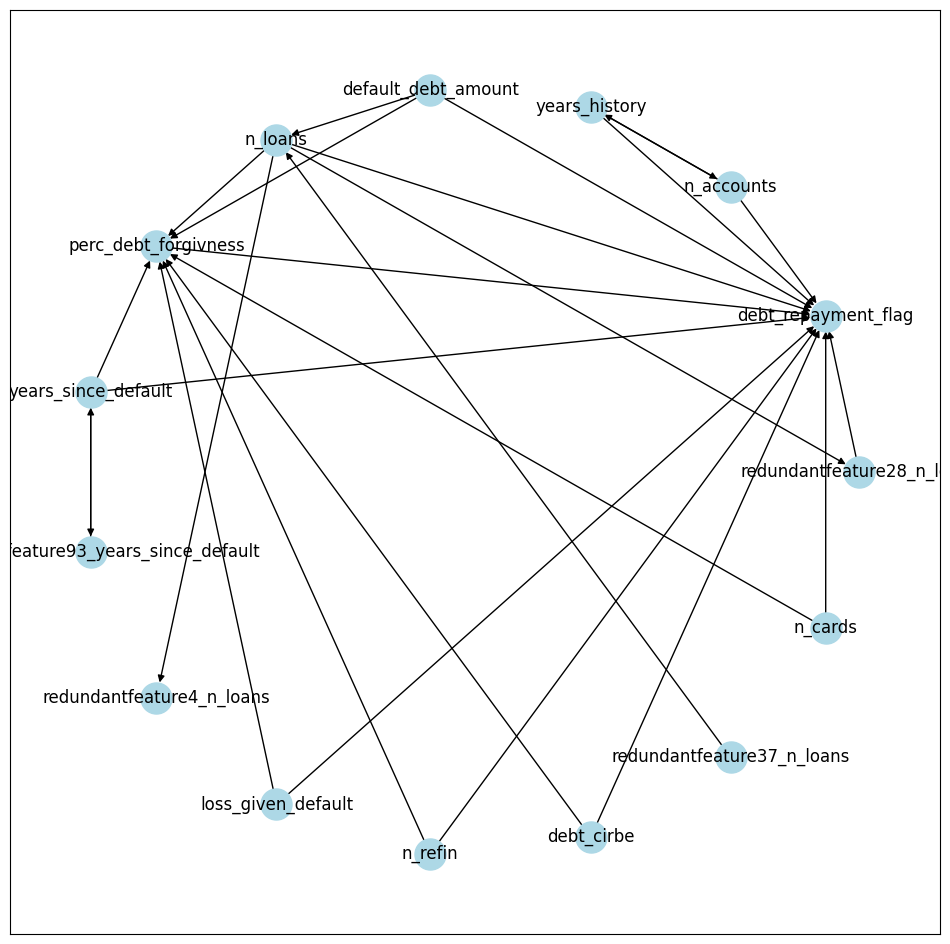

In [8]:
# gcastle
priori = create_prior(
    train[features_graph],
    "gcastle",
    TREATMENT,
    OUTCOME,
    "pc",
    force_treatmemnt_output=True,
)

pc_gcstle = PC(variant="original", alpha=0.01, ci_test="fisherz", priori_knowledge=priori)
pc_gcstle.learn(train_scaled[features_graph])

print(pc_gcstle.causal_matrix)

# plot predict_dag and true_dag
GraphDAG(pc_gcstle.causal_matrix)

# add edges from a list of tuples
edges_list = get_edges_list_from_gcastlegraph(pc_gcstle, features_graph)

# create a directed graph
pc_G = nx.DiGraph()
pc_G.add_edges_from(edges_list)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    pc_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(pc_G),
)
plt.show()

In [9]:
# Domain knowledge redirection
pc_G = redirect_edges_by_domain_knownledge(pc_G)

# First analyze the issues
problematic_edges = analyze_dag_issues(pc_G)

# If you want to automatically fix it
if len(problematic_edges) > 0:
    pc_G = make_dag(pc_G)

Found cycles:
redundantfeature93_years_since_default -> years_since_default -> redundantfeature93_years_since_default
n_accounts -> years_history -> n_accounts

Problematic edges that form cycles:
years_since_default -> redundantfeature93_years_since_default
years_history -> n_accounts
redundantfeature93_years_since_default -> years_since_default
n_accounts -> years_history
Removed edge: redundantfeature93_years_since_default -> years_since_default
Removed edge: n_accounts -> years_history


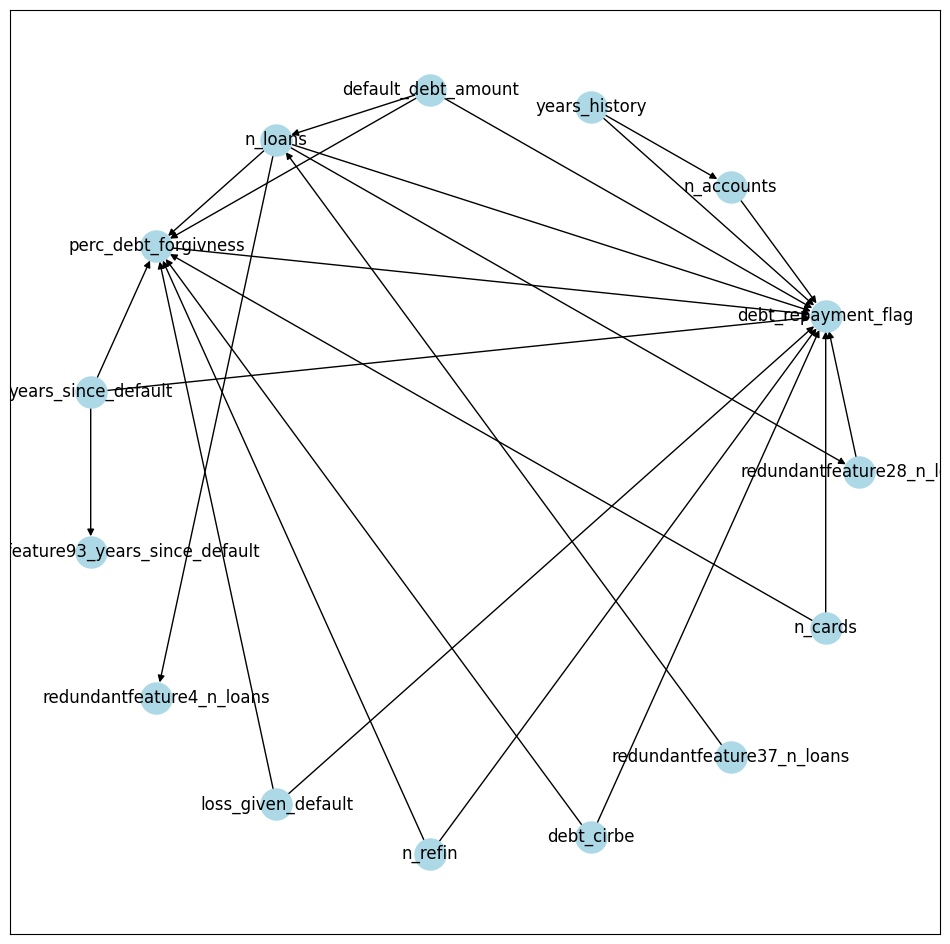

In [10]:
edges_list = [e for e in pc_G.edges]
if (TREATMENT, OUTCOME) not in edges_list:
    pc_G.add_edge(TREATMENT, OUTCOME)
    
# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    pc_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(pc_G),
)
plt.show()

In [11]:
model_pc = CausalModel(
    data=train[features_graph],
    treatment=TREATMENT,
    outcome=OUTCOME,
    graph="\n".join(nx.generate_gml(pc_G)),
)

# Identify the effect
identified_estimand_pc = model_pc.identify_effect()

print(identified_estimand_pc)

2025-01-24 11:14:42,091 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:505] - INFO: Model to find the causal effect of treatment ['perc_debt_forgivness'] on outcome ['debt_repayment_flag']
2025-01-24 11:14:42,878 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_identifier\auto_identifier.py[line:763] - INFO: Causal effect can be identified.
2025-01-24 11:14:42,878 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_identifier\auto_identifier.py[line:260] - INFO: Instrumental variables for treatment and outcome:[]
2025-01-24 11:14:42,878 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_identifier\auto_identifier.py[line:275] - INFO: Frontdoor variables for treatment and outcome:[]


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|n_loans,n_cards,loss_given_defau
d[perc_debt_forgivness]                                                       

                                                               
lt,debt_cirbe,n_refin,years_since_default,default_debt_amount])
                                                               
Estimand assumption 1, Unconfoundedness: If U→{perc_debt_forgivness} and U→debt_repayment_flag then P(debt_repayment_flag|perc_debt_forgivness,n_loans,n_cards,loss_given_default,debt_cirbe,n_refin,years_since_default,default_debt_amount,U) = P(debt_repayment_flag|perc_debt_forgivness,n_loans,n_cards,loss_given_default,debt_cirbe,n_refin,years_since_default,default_debt_amount)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3


In [12]:
estimate = model_pc.estimate_effect(
    identified_estimand_pc,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(estimate)

2025-01-24 11:14:42,931 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:329] - INFO: linear_regression
2025-01-24 11:14:42,933 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\linear_regression_estimator.py[line:70] - INFO: INFO: Using Linear Regression Estimator
2025-01-24 11:14:42,934 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\regression_estimator.py[line:147] - INFO: b: debt_repayment_flag~perc_debt_forgivness+n_loans+n_cards+loss_given_default+debt_cirbe+n_refin+years_since_default+default_debt_amount+perc_debt_forgivness*redundantfeature28_n_loans+perc_debt_forgivness*n_accounts+perc_debt_forgivness*years_history


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|n_loans,n_cards,loss_given_defau
d[perc_debt_forgivness]                                                       

                                                               
lt,debt_cirbe,n_refin,years_since_default,default_debt_amount])
                                                               
Estimand assumption 1, Unconfoundedness: If U→{perc_debt_forgivness} and U→debt_repayment_flag then P(debt_repayment_flag|perc_debt_forgivness,n_loans,n_cards,loss_given_default,debt_cirbe,n_refin,years_since_default,default_debt_amount,U) = P(debt_repayment_flag|perc_debt_forgivness,n_loans,n_cards,loss_given_default,debt_cirbe,n_refin,years_since_default,default_debt_amount)

## Realized estimand
b: debt_rep

## FCI

  0%|          | 0/15 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X2 --> X15
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X3 --> X15
Orienting edge (Knowledge): X4 --> X14
Orienting edge (Knowledge): X4 --> X15
Orienting edge (Knowledge): X5 --> X14
Orienting edge (Knowledge): X5 --> X15
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X6 --> X15
Orienting edge (Knowledge): X8 --> X14
Orienting edge (Knowledge): X8 --> X15
Orienting edge (Knowledge): X9 --> X15
Orienting edge (Knowledge): X10 --> X14
Orienting edge (Knowledge): X10 --> X15
Orienting edge (Knowledge): X13 --> X14
Orienting edge (Knowledge): X13 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X2 --> X15
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X3 --> X15
Orienting edge (Knowledge): X4 --> X14
Orienting edge (Knowledge): X4 --> X15
Orienting edge (Knowledge): X5 --> X14
Orienting edge (Knowledge): X5 --> X15
Orienting edge (Knowled

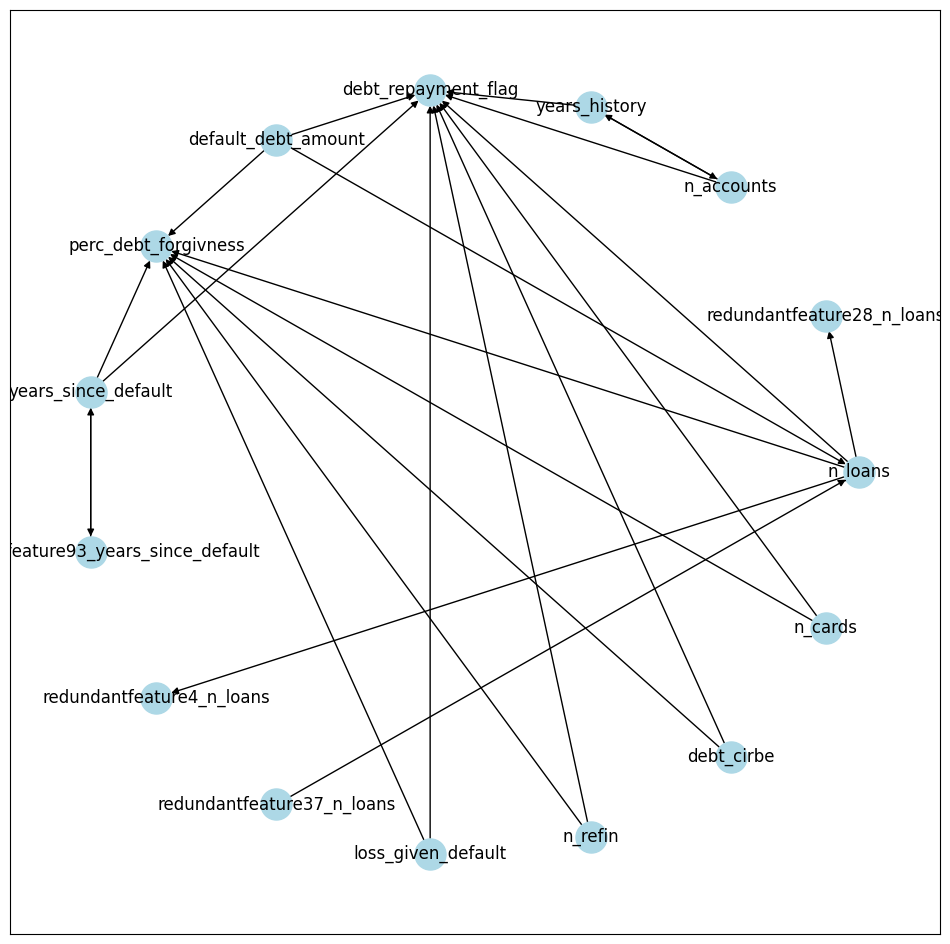

In [13]:
priori = create_prior(
    train_scaled[features_graph],
    "causal-learn",
    TREATMENT,
    OUTCOME,
    algorithm="fci",
    force_treatmemnt_output=True,
)

# or customized parameters
graph_fci, edges = fci(
    dataset=train_scaled[features_graph].to_numpy(),
    independence_test_method="fisherz",  # kci
    background_knowledge=priori,
    alpha=0.01,
)

fci_G = get_nx_graph_FCI(graph_fci.graph, features_graph)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    fci_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(fci_G),
)
plt.show()

In [14]:
# Domain knowledge redirection
fci_G = redirect_edges_by_domain_knownledge(fci_G)

# First analyze the issues
problematic_edges = analyze_dag_issues(fci_G)

# If you want to automatically fix it
if len(problematic_edges) > 0:
    fci_G = make_dag(fci_G)

Found cycles:
redundantfeature93_years_since_default -> years_since_default -> redundantfeature93_years_since_default
n_accounts -> years_history -> n_accounts

Problematic edges that form cycles:
years_since_default -> redundantfeature93_years_since_default
years_history -> n_accounts
redundantfeature93_years_since_default -> years_since_default
n_accounts -> years_history
Removed edge: redundantfeature93_years_since_default -> years_since_default
Removed edge: n_accounts -> years_history


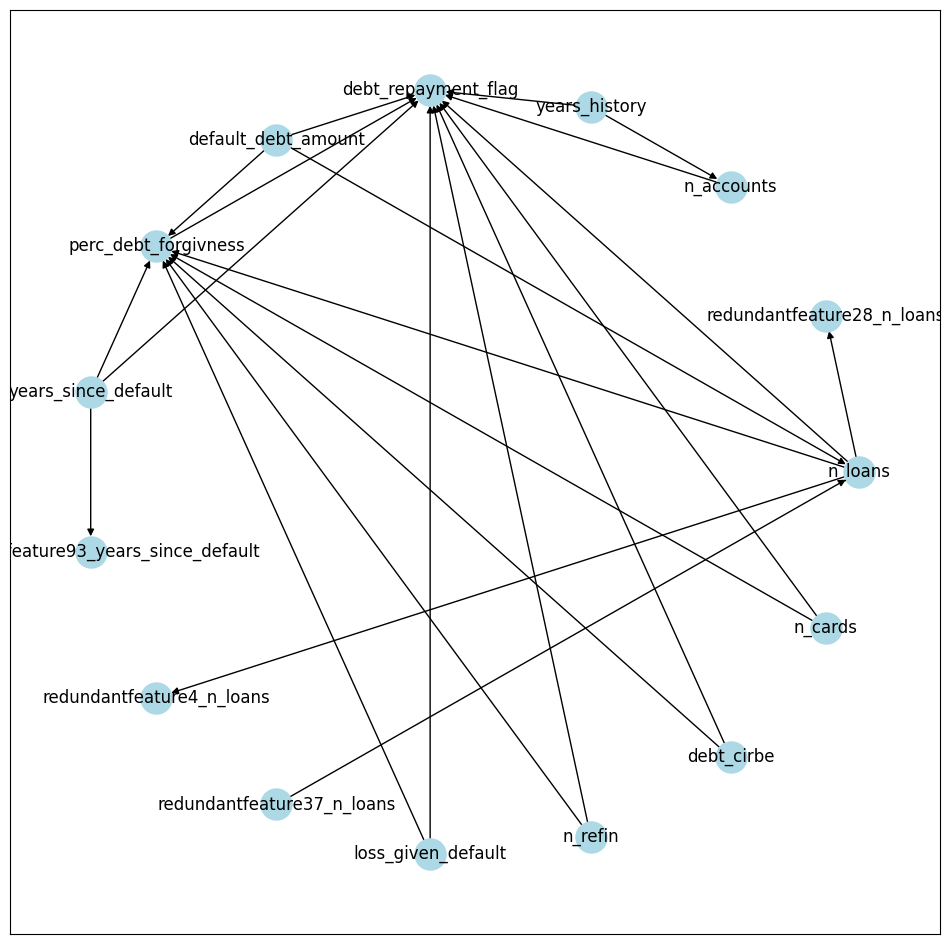

In [15]:
# force connection
edges_list = [e for e in fci_G.edges]
if (TREATMENT, OUTCOME) not in edges_list:
    fci_G.add_edge(TREATMENT, OUTCOME)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    fci_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(fci_G),
)
plt.show()

In [16]:
model_fci = CausalModel(
    data=train[features_graph],
    treatment=TREATMENT,
    outcome=OUTCOME,
    graph="\n".join(nx.generate_gml(fci_G)),
)

# Identify the effect
identified_estimand_fci = model_fci.identify_effect()

print(identified_estimand_fci)

2025-01-24 11:14:44,815 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:505] - INFO: Model to find the causal effect of treatment ['perc_debt_forgivness'] on outcome ['debt_repayment_flag']
2025-01-24 11:14:45,627 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_identifier\auto_identifier.py[line:763] - INFO: Causal effect can be identified.
2025-01-24 11:14:45,627 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_identifier\auto_identifier.py[line:260] - INFO: Instrumental variables for treatment and outcome:[]
2025-01-24 11:14:45,627 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_identifier\auto_identifier.py[line:275] - INFO: Frontdoor variables for treatment and outcome:[]


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|n_loans,n_cards,loss_given_defau
d[perc_debt_forgivness]                                                       

                                                               
lt,debt_cirbe,n_refin,years_since_default,default_debt_amount])
                                                               
Estimand assumption 1, Unconfoundedness: If U→{perc_debt_forgivness} and U→debt_repayment_flag then P(debt_repayment_flag|perc_debt_forgivness,n_loans,n_cards,loss_given_default,debt_cirbe,n_refin,years_since_default,default_debt_amount,U) = P(debt_repayment_flag|perc_debt_forgivness,n_loans,n_cards,loss_given_default,debt_cirbe,n_refin,years_since_default,default_debt_amount)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3


In [17]:
estimate = model_fci.estimate_effect(
    identified_estimand_fci,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(estimate)

2025-01-24 11:14:45,649 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:329] - INFO: linear_regression
2025-01-24 11:14:45,655 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\linear_regression_estimator.py[line:70] - INFO: INFO: Using Linear Regression Estimator
2025-01-24 11:14:45,656 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\regression_estimator.py[line:147] - INFO: b: debt_repayment_flag~perc_debt_forgivness+n_loans+n_cards+loss_given_default+debt_cirbe+n_refin+years_since_default+default_debt_amount+perc_debt_forgivness*n_accounts+perc_debt_forgivness*years_history


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|n_loans,n_cards,loss_given_defau
d[perc_debt_forgivness]                                                       

                                                               
lt,debt_cirbe,n_refin,years_since_default,default_debt_amount])
                                                               
Estimand assumption 1, Unconfoundedness: If U→{perc_debt_forgivness} and U→debt_repayment_flag then P(debt_repayment_flag|perc_debt_forgivness,n_loans,n_cards,loss_given_default,debt_cirbe,n_refin,years_since_default,default_debt_amount,U) = P(debt_repayment_flag|perc_debt_forgivness,n_loans,n_cards,loss_given_default,debt_cirbe,n_refin,years_since_default,default_debt_amount)

## Realized estimand
b: debt_rep

## GES

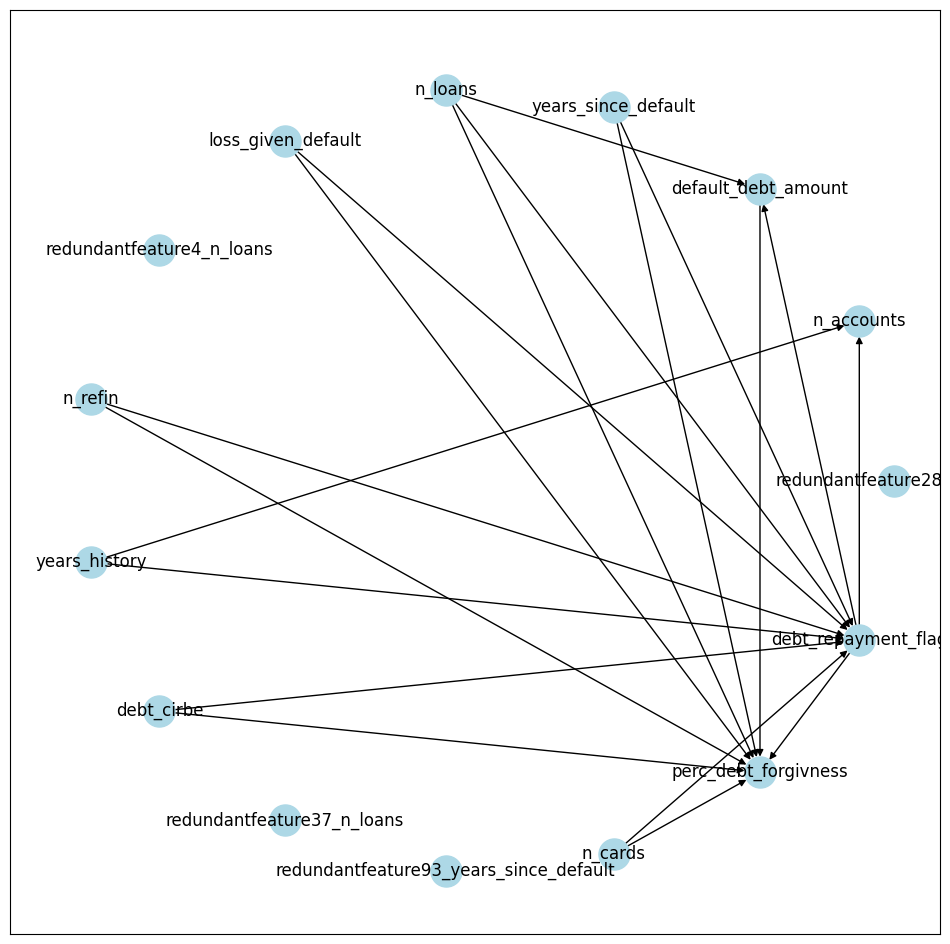

In [18]:
graph_ges = ges(
    train_scaled[features_graph], 
    score_func="local_score_BIC", 
    maxP=None, 
    parameters={"kfold": 5}
)

ges_G = get_nx_graph_ges(graph_ges, feature_names=features_graph)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    ges_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(ges_G),
)
plt.show()


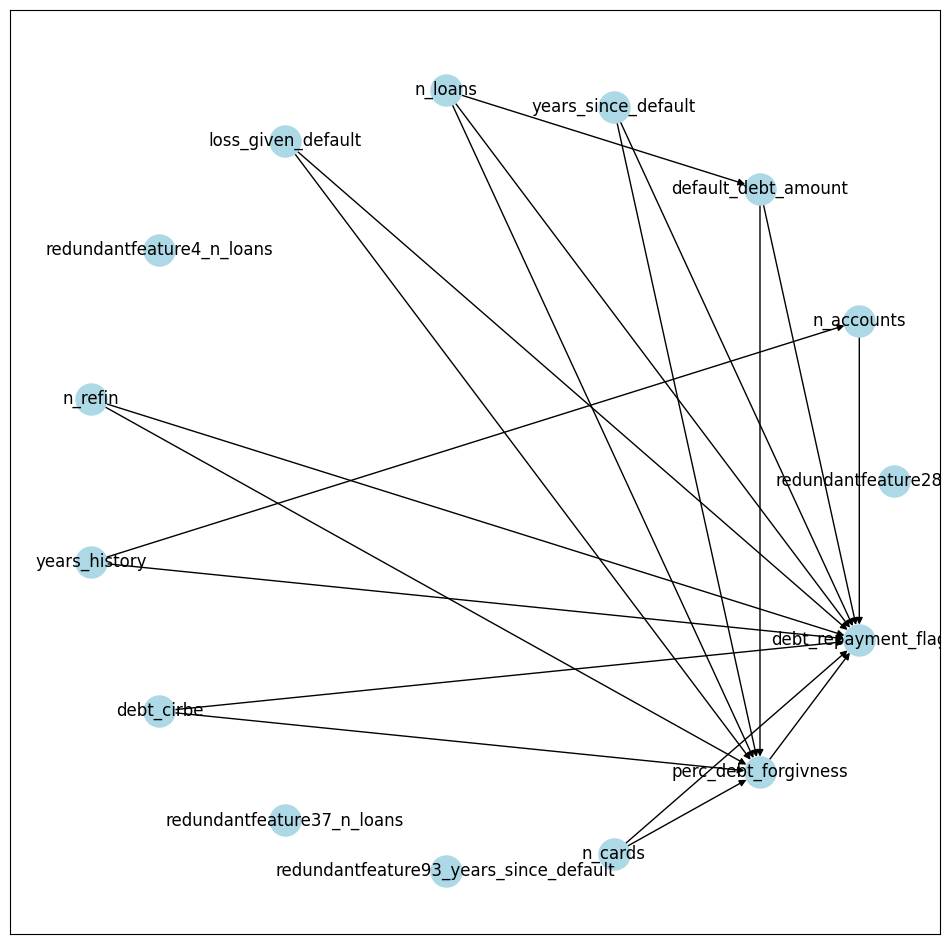

In [19]:
# Domain knowledge redirection
ges_G = redirect_edges_by_domain_knownledge(ges_G)

# force connection
edges_list = [e for e in ges_G.edges]
if (TREATMENT, OUTCOME) not in edges_list:
    ges_G.add_edge(TREATMENT, OUTCOME)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    ges_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(ges_G),
)
plt.show()

In [20]:
model_ges = CausalModel(
    data=train[features_graph],
    treatment=TREATMENT,
    outcome=OUTCOME,
    graph="\n".join(nx.generate_gml(ges_G)),
)

# Identify the effect
identified_estimand_ges = model_ges.identify_effect()

print(identified_estimand_ges)

2025-01-24 11:14:54,396 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:505] - INFO: Model to find the causal effect of treatment ['perc_debt_forgivness'] on outcome ['debt_repayment_flag']
2025-01-24 11:14:54,456 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_identifier\auto_identifier.py[line:763] - INFO: Causal effect can be identified.
2025-01-24 11:14:54,456 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_identifier\auto_identifier.py[line:260] - INFO: Instrumental variables for treatment and outcome:[]
2025-01-24 11:14:54,456 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_identifier\auto_identifier.py[line:275] - INFO: Frontdoor variables for treatment and outcome:[]


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|n_loans,n_cards,loss_given_defau
d[perc_debt_forgivness]                                                       

                                                               
lt,debt_cirbe,n_refin,default_debt_amount,years_since_default])
                                                               
Estimand assumption 1, Unconfoundedness: If U→{perc_debt_forgivness} and U→debt_repayment_flag then P(debt_repayment_flag|perc_debt_forgivness,n_loans,n_cards,loss_given_default,debt_cirbe,n_refin,default_debt_amount,years_since_default,U) = P(debt_repayment_flag|perc_debt_forgivness,n_loans,n_cards,loss_given_default,debt_cirbe,n_refin,default_debt_amount,years_since_default)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3


In [21]:
estimate = model_ges.estimate_effect(
    identified_estimand_ges,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(estimate)

2025-01-24 11:14:54,498 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:329] - INFO: linear_regression
2025-01-24 11:14:54,498 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\linear_regression_estimator.py[line:70] - INFO: INFO: Using Linear Regression Estimator
2025-01-24 11:14:54,498 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\regression_estimator.py[line:147] - INFO: b: debt_repayment_flag~perc_debt_forgivness+n_loans+n_cards+loss_given_default+debt_cirbe+n_refin+default_debt_amount+years_since_default+perc_debt_forgivness*n_accounts+perc_debt_forgivness*years_history


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|n_loans,n_cards,loss_given_defau
d[perc_debt_forgivness]                                                       

                                                               
lt,debt_cirbe,n_refin,default_debt_amount,years_since_default])
                                                               
Estimand assumption 1, Unconfoundedness: If U→{perc_debt_forgivness} and U→debt_repayment_flag then P(debt_repayment_flag|perc_debt_forgivness,n_loans,n_cards,loss_given_default,debt_cirbe,n_refin,default_debt_amount,years_since_default,U) = P(debt_repayment_flag|perc_debt_forgivness,n_loans,n_cards,loss_given_default,debt_cirbe,n_refin,default_debt_amount,years_since_default)

## Realized estimand
b: debt_rep

# Save data

In [22]:
backdoor_variables_pc = identified_estimand_pc.get_backdoor_variables()
print("Backdoor adjustment set PC:", backdoor_variables_pc)

Backdoor adjustment set PC: ['n_loans', 'n_cards', 'loss_given_default', 'debt_cirbe', 'n_refin', 'years_since_default', 'default_debt_amount']


In [23]:
outcome_causes_pc = get_outcome_only_causes(pc_G, OUTCOME, TREATMENT)

Features that cause ONLY the outcome: ['redundantfeature28_n_loans', 'n_accounts', 'years_history']


In [24]:
backdoor_variables_fci = identified_estimand_fci.get_backdoor_variables()
print("Backdoor adjustment set FCI:", backdoor_variables_fci)


Backdoor adjustment set FCI: ['n_loans', 'n_cards', 'loss_given_default', 'debt_cirbe', 'n_refin', 'years_since_default', 'default_debt_amount']


In [25]:
outcome_causes_fci = get_outcome_only_causes(fci_G, OUTCOME, TREATMENT)

Features that cause ONLY the outcome: ['n_accounts', 'years_history']


In [26]:
backdoor_variables_ges = identified_estimand_ges.get_backdoor_variables()
print("Backdoor adjustment set GES:", backdoor_variables_ges)

Backdoor adjustment set GES: ['n_loans', 'n_cards', 'loss_given_default', 'debt_cirbe', 'n_refin', 'default_debt_amount', 'years_since_default']


In [27]:
outcome_causes_ges = get_outcome_only_causes(ges_G, OUTCOME, TREATMENT)

Features that cause ONLY the outcome: ['years_history', 'n_accounts']


In [28]:
backdoor_variables = list(set(backdoor_variables_pc) & set(backdoor_variables_fci) & set(backdoor_variables_ges))
len(backdoor_variables)
backdoor_variables

['n_loans',
 'n_cards',
 'loss_given_default',
 'debt_cirbe',
 'n_refin',
 'default_debt_amount',
 'years_since_default']

In [29]:
outcome_causes = list(set(outcome_causes_pc) & set(outcome_causes_fci) & set(outcome_causes_ges))
len(outcome_causes)
outcome_causes

['n_accounts', 'years_history']

In [30]:
!rm -rf CONTROLS_PATH
with open(CONTROLS_PATH, "w") as output:
    for row in backdoor_variables:
        output.write(str(row) + "\n")

"rm" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [31]:
!rm -rf OUTCOME_CAUSES_PATH
with open(OUTCOME_CAUSES_PATH, "w") as output:
    for row in outcome_causes:
        output.write(str(row) + "\n")

"rm" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
